https://chatgpt.com/share/68703dc5-4ff0-8008-9153-42348685b941

In [1]:
import gspread
import pandas as pd
import re
from gspread_dataframe import get_as_dataframe
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.size": 15,  # 默认字体大小
        "axes.titlesize": 17,  # 标题字体
        "axes.labelsize": 15,  # 坐标轴标签
        "xtick.labelsize": 13,  # x 轴刻度
        "ytick.labelsize": 13,  # y 轴刻度
        "legend.fontsize": 13,  # 图例字体
    }
)

In [9]:
CREDENTIALS_JSON = '../rm4mt-463314-3ce1280ee29c.json'
sheet_urls = [
    "https://docs.google.com/spreadsheets/d/1yhLFAwm-sFAG2cDxDBQ6C0smcM_f5uQxYuy_clvgueM/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/1LHsMMvKhTEgagmZKQl7ax1H4BJyDBImYMbeE8sNPjJw/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/19sowSDpBO42OSXFeBM92UBp1H2MZkQQWzEAPMpZz9q4/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/1PRIfwNA4l2TG3oMFlgM8LIGuxvCH8prfgEvbGMDhqIY/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/16nVSzWScuuYThX2ZgQAyZ0V5ip5d1GFPKCABjG6IHf8/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/11WAU3v3uKN1wV3G7crmGDyo3u4QX4aGlhWpQN7tn9As/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/1k_zR5v7em_iz1J3K6p4qRYvFrzbFDOjI8lLWtPK3YCM/edit?usp=sharing",
    # "https://docs.google.com/spreadsheets/d/1pSBxhdqGvu2I5z_8C6l6pePV-IkIl31MM83Py_ILRqU/edit?usp=sharing",
]

In [10]:
gc = gspread.service_account(filename=CREDENTIALS_JSON)
all_data = {}

In [11]:
for sheet_url in sheet_urls:
    print(f"Reading Sheet: {sheet_url}")
    spreadsheet = gc.open_by_url(sheet_url)
    ws_data = {}
    for worksheet in spreadsheet.worksheets():
        # print(f"  Worksheet: {worksheet.title}")
        df = get_as_dataframe(worksheet, evaluate_formulas=True)
        df = df.dropna(how='all').dropna(axis=1, how='all')
        ws_data[worksheet.title] = df
        time.sleep(2)
    all_data[sheet_url] = ws_data

Reading Sheet: https://docs.google.com/spreadsheets/d/1yhLFAwm-sFAG2cDxDBQ6C0smcM_f5uQxYuy_clvgueM/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/19sowSDpBO42OSXFeBM92UBp1H2MZkQQWzEAPMpZz9q4/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/16nVSzWScuuYThX2ZgQAyZ0V5ip5d1GFPKCABjG6IHf8/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1k_zR5v7em_iz1J3K6p4qRYvFrzbFDOjI8lLWtPK3YCM/edit?usp=sharing


In [12]:
def split_by_metric(all_data):
    dfs_by_metric = defaultdict(list)  # metric: list of rows

    for sheet_url, ws_dict in all_data.items():
        for ws_name, df in ws_dict.items():
            match = re.match(
                r"(.+?)_((comet_score|comet_kiwi_score|grb|grf|gea_100|gea_5|thinking_length))$",
                ws_name,
            )
            if not match:
                continue
            task = match.group(1)
            metric = match.group(2)
            # Check must have model & lang_pair
            if not {"model", "lang_pair"}.issubset(df.columns):
                continue
            # Budget Column - include numeric columns and "low", "high"
            numeric_cols = [
                col
                for col in df.columns
                if isinstance(col, (int, float))
                or (isinstance(col, str) and col.isdigit())
            ]
            text_budget_cols = [col for col in df.columns if col in ["low", "high"]]
            budget_cols = sorted(numeric_cols, key=lambda x: int(x)) + text_budget_cols

            for _, row in df.iterrows():
                model = row["model"]
                lang_pair = row["lang_pair"]
                for budget in budget_cols:
                    val = row[budget]
                    if pd.isna(val):
                        continue
                    # Handle budget value - keep as string for "low"/"high", convert to int for numeric
                    budget_val = budget if budget in ["low", "high"] else int(budget)
                    dfs_by_metric[metric].append(
                        {
                            "model": model,
                            "task": task,
                            "metric": metric,
                            "lang_pair": lang_pair,
                            "budget": budget_val,
                            "score": float(val),
                        }
                    )

    # To DataFrame
    for metric in dfs_by_metric:
        dfs_by_metric[metric] = pd.DataFrame(dfs_by_metric[metric])

    return dfs_by_metric


dfs_by_metric = split_by_metric(all_data)

In [13]:
print("Available Metrics:")
print(list(dfs_by_metric.keys()))

Available Metrics:
['comet_score', 'comet_kiwi_score', 'grb', 'grf', 'gea_100', 'gea_5', 'thinking_length']


In [14]:
dfs_by_metric['grb']

,model,task,metric,lang_pair,budget,score
0,DRT-14B,WMT23-Biomedical-Doc,grb,Avg,100,75.289575
1,DRT-14B,WMT23-Biomedical-Doc,grb,Avg,200,72.036036
2,DRT-14B,WMT23-Biomedical-Doc,grb,Avg,300,72.203799
3,DRT-14B,WMT23-Biomedical-Doc,grb,Avg,400,70.501758
4,DRT-14B,WMT23-Biomedical-Doc,grb,Avg,500,72.268360
...,...,...,...,...,...,...
5911,cogito-v1-preview-llama-8B,RAGtrans,grb,en-zh,2000,92.294500
5912,grok-3-mini,RAGtrans,grb,Avg,high,95.096000
5913,grok-3-mini,RAGtrans,grb,Avg,low,95.068000
5914,grok-3-mini,RAGtrans,grb,en-zh,high,95.096000


In [15]:
def plot_model_scores(
    df, 
    task, 
    lang_pair, 
    models,
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(7,5)
):
    plot_df = df[
        (df['task'] == task) &
        (df['lang_pair'] == lang_pair) &
        (df['model'].isin(models))
    ]
    if plot_df.empty:
        print('No data found for the given criteria. Please check')
        return
    
    plt.figure(figsize=figsize)
    for model in models:
        sub = plot_df[plot_df['model'] == model]
        sub = sub.sort_values('budget')
        plt.plot(sub['budget'], sub['score'], marker='o', label=model)
    plt.xlabel('Budget')
    plt.ylabel('Score')
    plt.title(f'{task} | {lang_pair}')
    plt.xticks(budget_ticks)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [16]:
# plot_model_scores(
#     dfs_by_metric['grb'],
#     task='WMT23-Biomedical-Sentence',
#     lang_pair='Avg',
#     # models=['Qwen3-0.6B', 'Qwen3-1.7B']
#     # models=['Qwen3-4B', 'Qwen3-8B']
#     # models=['Qwen3-14B', 'Qwen3-32B']
# )

In [17]:
def sort_budget_key(b):
    if isinstance(b, (int, float)):
        return (0, b)
    elif isinstance(b, str):
        if b.isdigit():
            return (0, int(b))
        elif b == "low":
            return (1, 0)
        elif b == "high":
            return (2, 0)
    return (3, str(b))


def plot_models_groups_side_by_side(
    df,
    task,
    metric,
    lang_pair,
    model_groups,
    budget_ticks=None,
    figsize=(16, 5),
):
    n_groups = len(model_groups)
    fig, axes = plt.subplots(1, n_groups, figsize=figsize, sharey=True)
    if n_groups == 1:
        axes = [axes]

    for idx, models in enumerate(model_groups):
        ax = axes[idx]
        group_df = df[
            (df["task"] == task)
            & (df["metric"] == metric)
            & (df["lang_pair"] == lang_pair)
            & (df["model"].isin(models))
        ]
        if group_df.empty:
            ax.set_title("No data available for this group")
            continue

        # First, determine the nature of the budget axis for this group
        all_budgets = set(group_df["budget"])
        sorted_budgets = sorted(all_budgets, key=sort_budget_key)
        is_numeric_group = all(
            isinstance(b, (int, float)) or (isinstance(b, str) and b.isdigit())
            for b in sorted_budgets
        )

        # Plot each model in the group
        for model in models:
            sub = group_df[group_df["model"] == model].copy()
            if sub.empty:
                continue
            sub = sub.sort_values(by="budget", key=lambda x: x.map(sort_budget_key))

            x_values = sub["budget"]
            if is_numeric_group:
                # If all budgets are numeric-like, plot them as numbers
                x_values = x_values.astype(int)
            else:
                # Otherwise, plot as strings (categorical)
                x_values = x_values.astype(str)

            ax.plot(x_values, sub["score"], marker="o", label=model)

        # Set the x-ticks based on whether the axis is numeric or categorical
        if is_numeric_group:
            # For a numeric axis, set numeric ticks
            ticks = (
                budget_ticks
                if budget_ticks is not None
                else [int(b) for b in sorted_budgets]
            )
            ax.set_xticks(ticks)
            ax.set_xticklabels(ticks, rotation=45)
        else:
            # For a categorical axis, set string ticks
            xticks = [str(b) for b in sorted_budgets]
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticks, rotation=45)

        ax.set_xlabel("Budget")
        ax.grid(True)
        if idx == 0:
            ax.set_ylabel(f"{metric.upper()} Score")
        ax.legend(loc="lower right", framealpha=0.25)

    # plt.suptitle(f"{task} | {metric} | {lang_pair}")
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

### Biomedical Translation

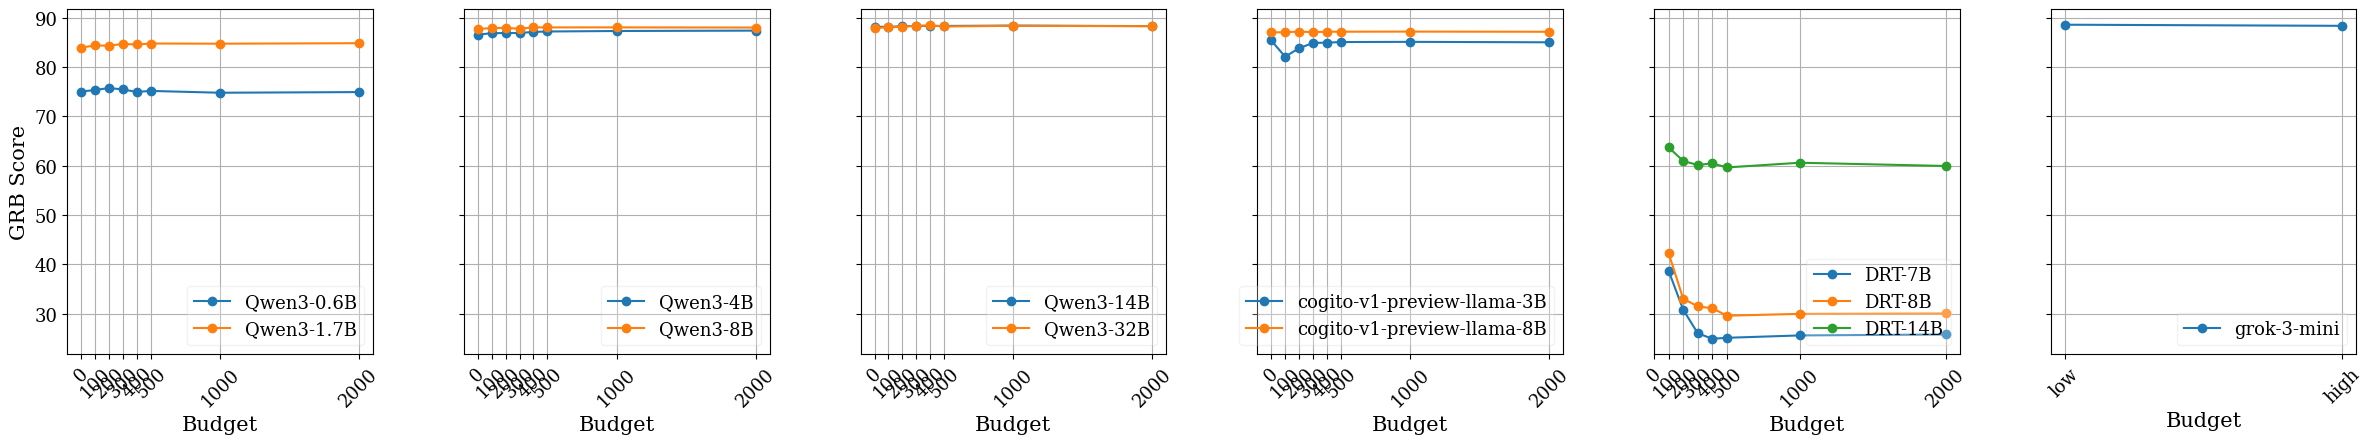

In [18]:
plot_models_groups_side_by_side(
    dfs_by_metric["grb"],
    task="WMT23-Biomedical-Sentence",
    metric="grb",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["cogito-v1-preview-llama-3B", "cogito-v1-preview-llama-8B"],
        ["DRT-7B", "DRT-8B", "DRT-14B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5),
)

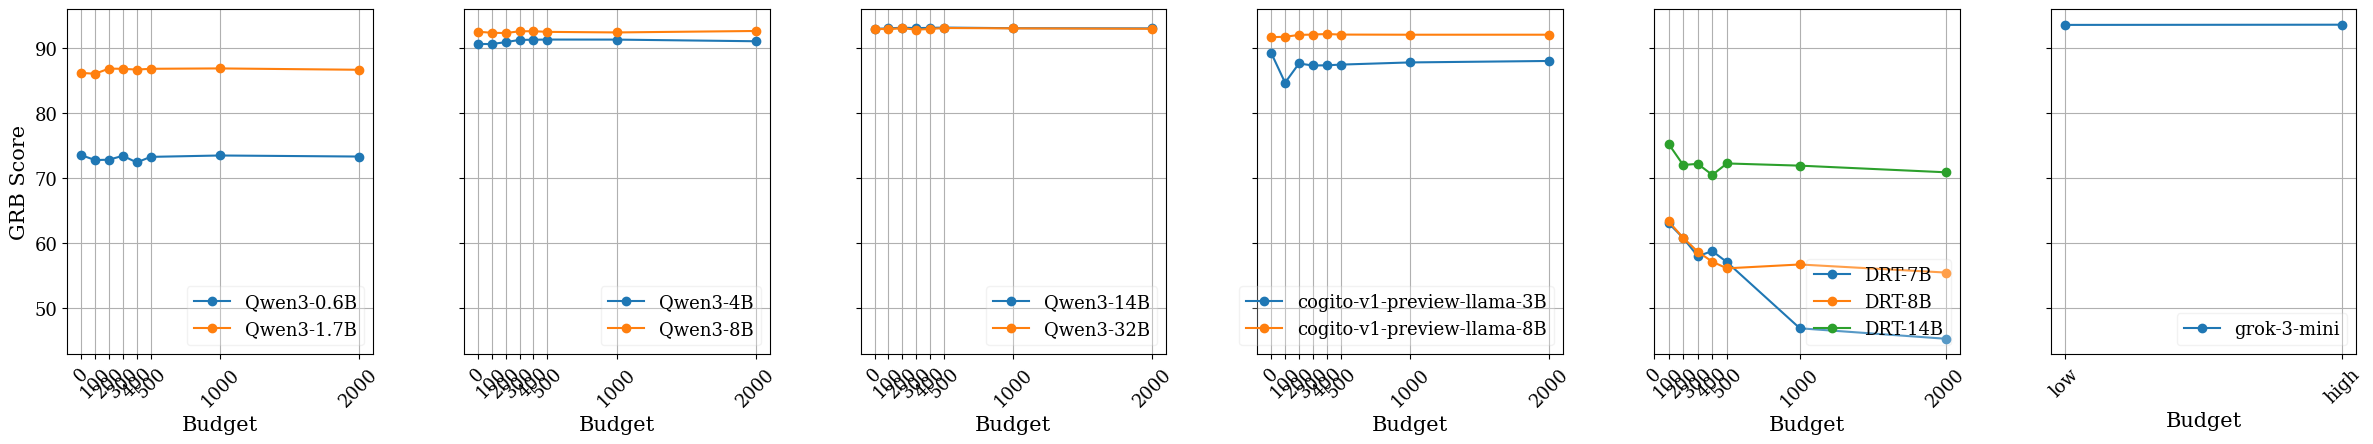

In [19]:
plot_models_groups_side_by_side(
    dfs_by_metric["grb"],
    task="WMT23-Biomedical-Doc",
    metric="grb",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["cogito-v1-preview-llama-3B", "cogito-v1-preview-llama-8B"],
        ["DRT-7B", "DRT-8B", "DRT-14B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5),
)

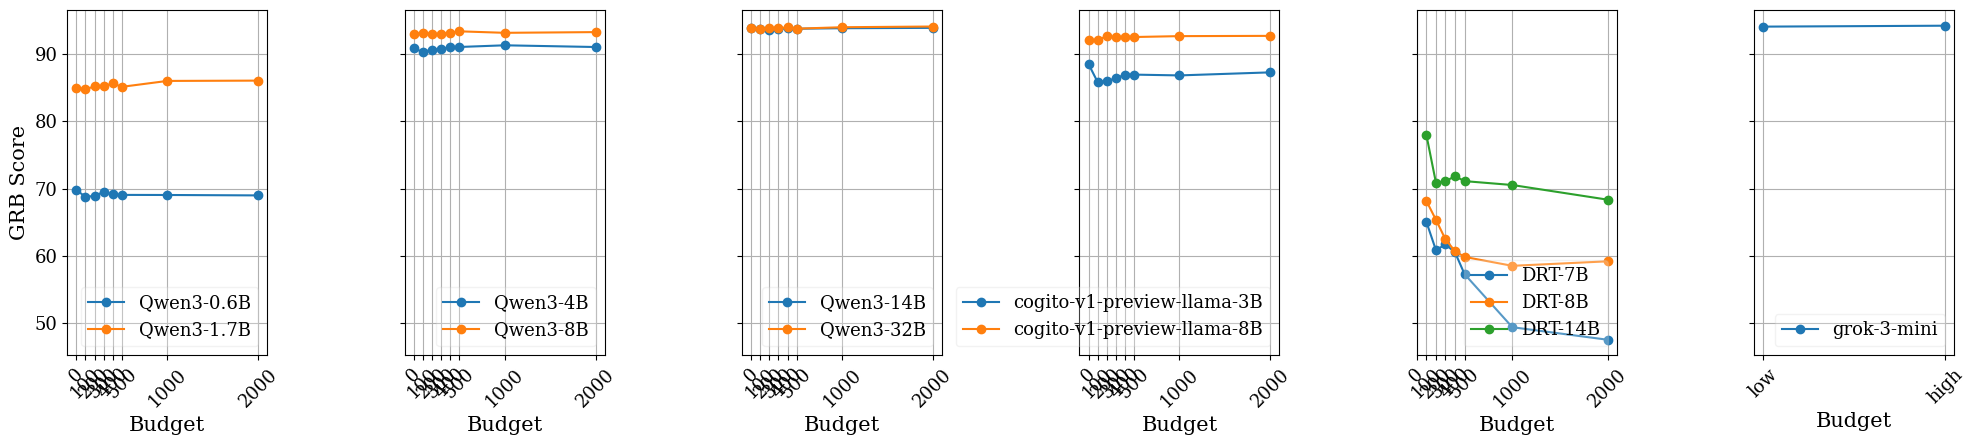

In [20]:
plot_models_groups_side_by_side(
    dfs_by_metric["grb"],
    task="WMT24-Biomedical",
    metric="grb",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["cogito-v1-preview-llama-3B", "cogito-v1-preview-llama-8B"],
        ["DRT-7B", "DRT-8B", "DRT-14B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(20, 5),
)

### Terminminology Translation

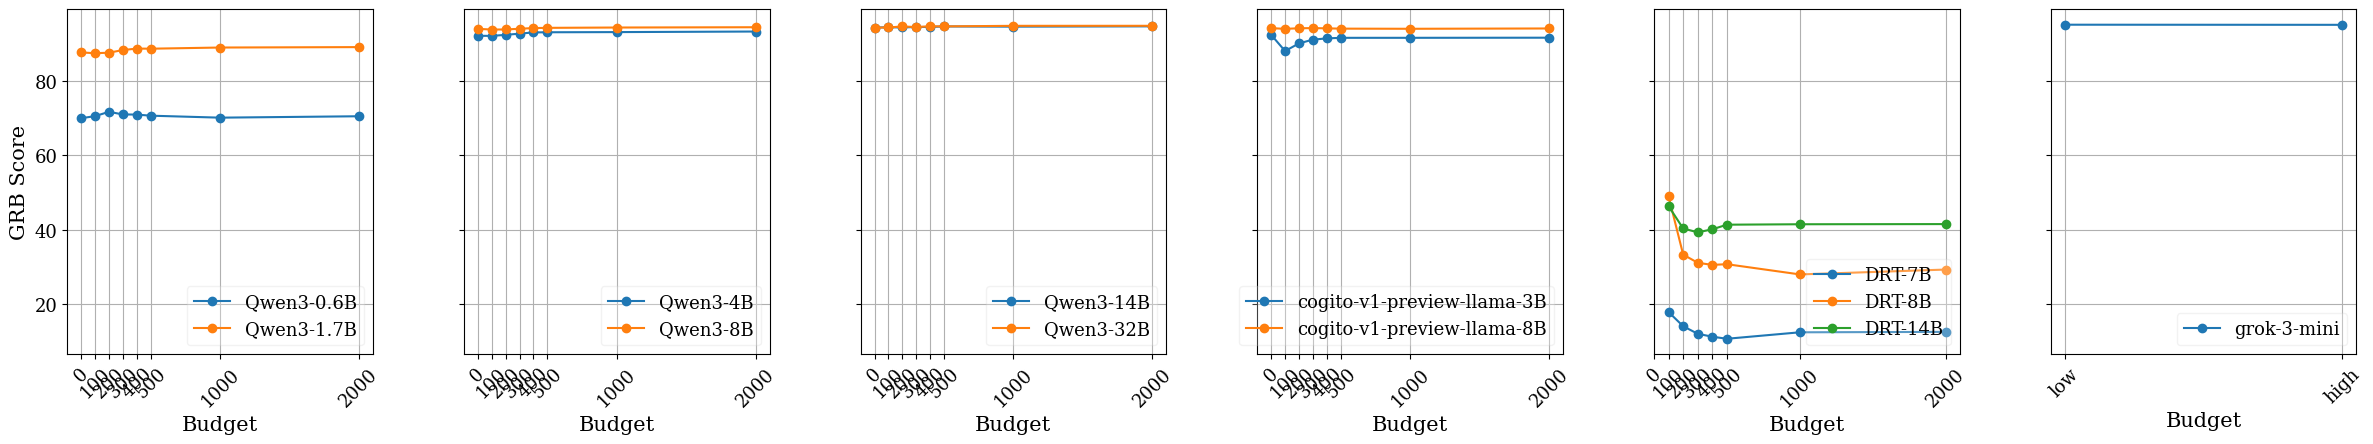

In [21]:
plot_models_groups_side_by_side(
    dfs_by_metric["grb"],
    task="RTT",
    metric="grb",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["cogito-v1-preview-llama-3B", "cogito-v1-preview-llama-8B"],
        ["DRT-7B", "DRT-8B", "DRT-14B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5),
)

### Commosence Translation

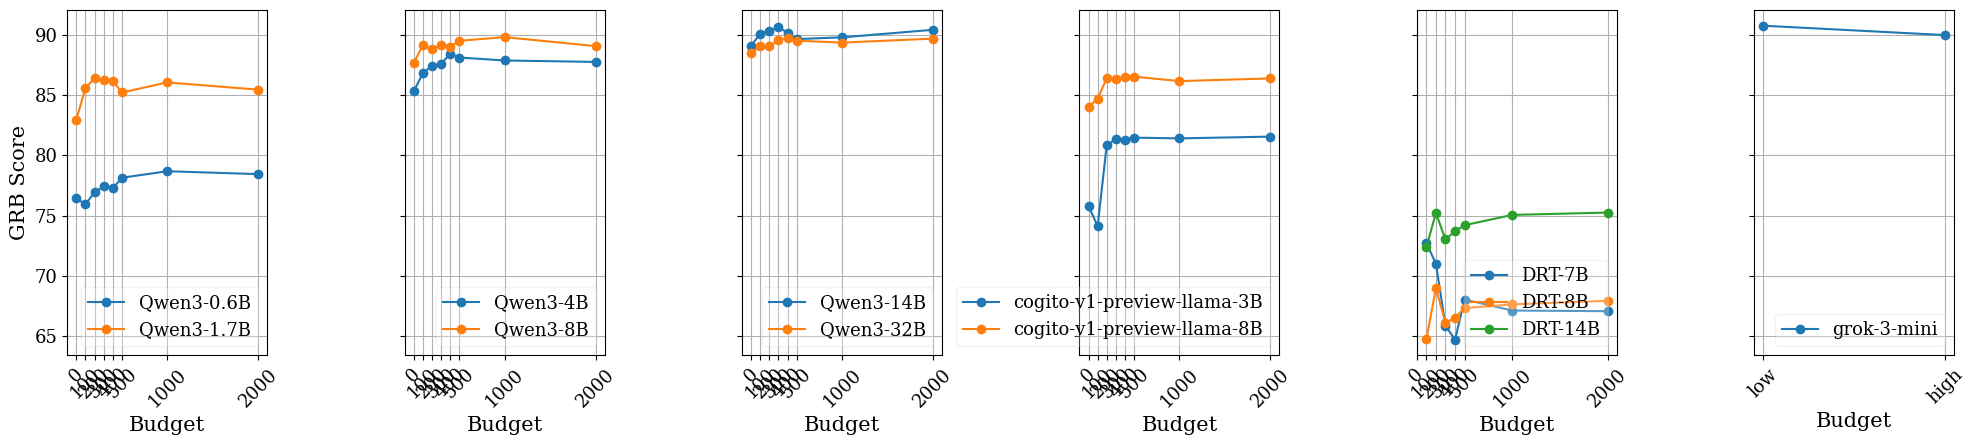

In [22]:
plot_models_groups_side_by_side(
    dfs_by_metric["grb"],
    task="CommonsenseMT-Contextless",
    metric="grb",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["cogito-v1-preview-llama-3B", "cogito-v1-preview-llama-8B"],
        ["DRT-7B", "DRT-8B", "DRT-14B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(20, 5),
)

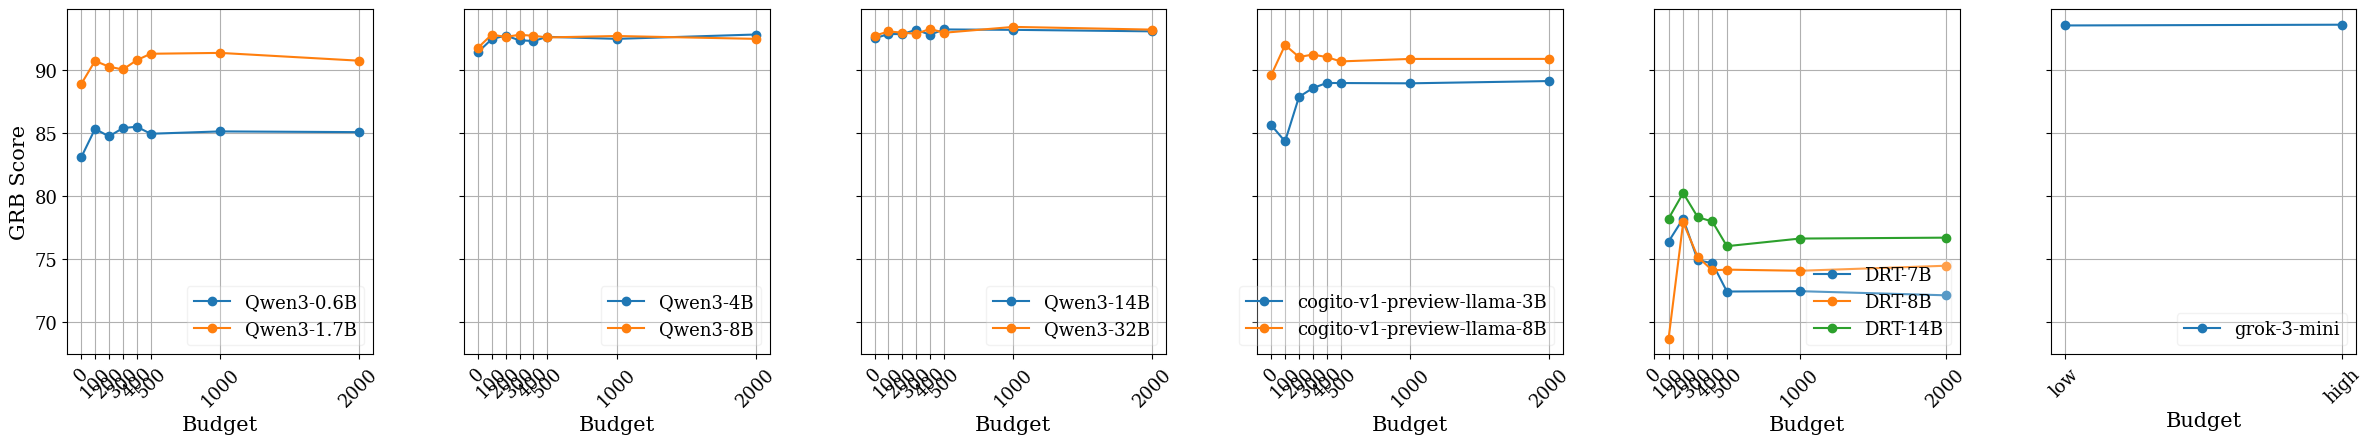

In [23]:
plot_models_groups_side_by_side(
    dfs_by_metric["grb"],
    task="CommonsenseMT-Contextual",
    metric="grb",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["cogito-v1-preview-llama-3B", "cogito-v1-preview-llama-8B"],
        ["DRT-7B", "DRT-8B", "DRT-14B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5),
)

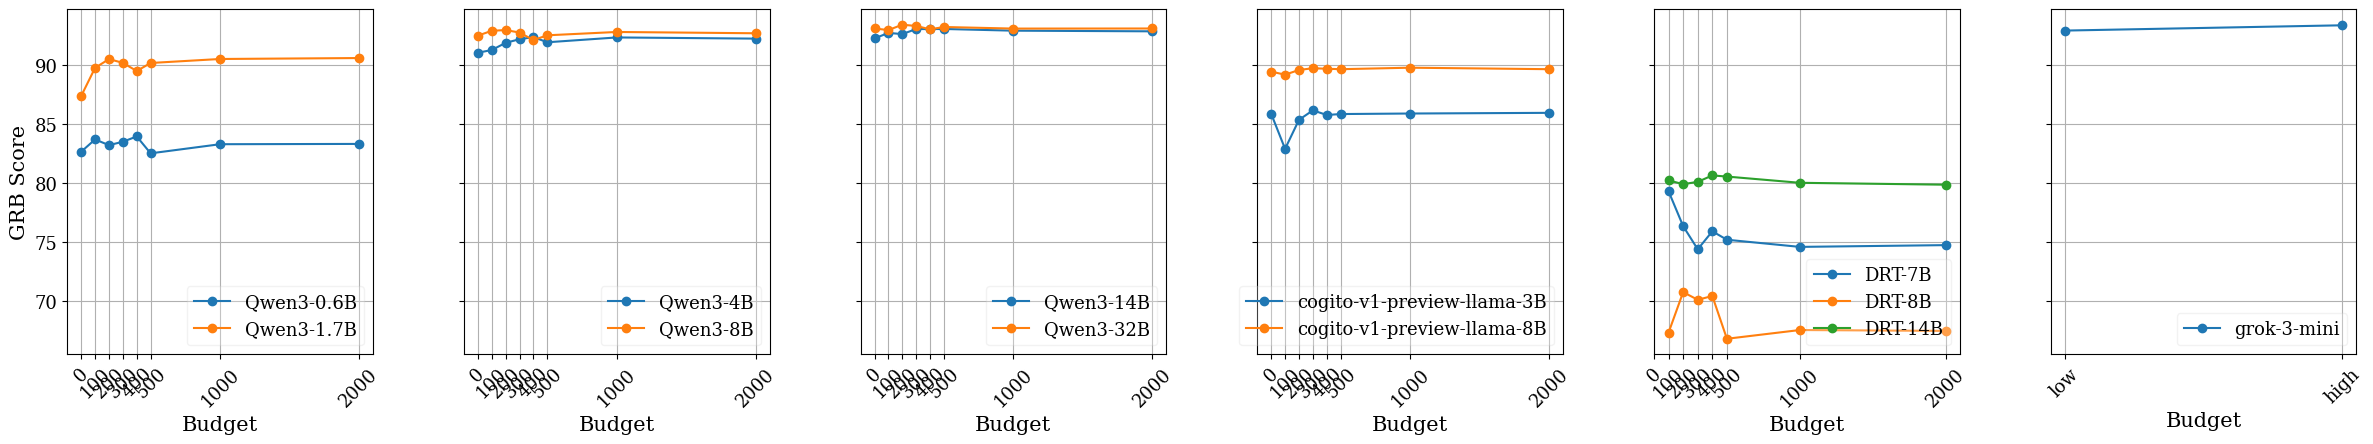

In [24]:
plot_models_groups_side_by_side(
    dfs_by_metric["grb"],
    task="CommonsenseMT-Lexical",
    metric="grb",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["cogito-v1-preview-llama-3B", "cogito-v1-preview-llama-8B"],
        ["DRT-7B", "DRT-8B", "DRT-14B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5),
)

### Culture Translation

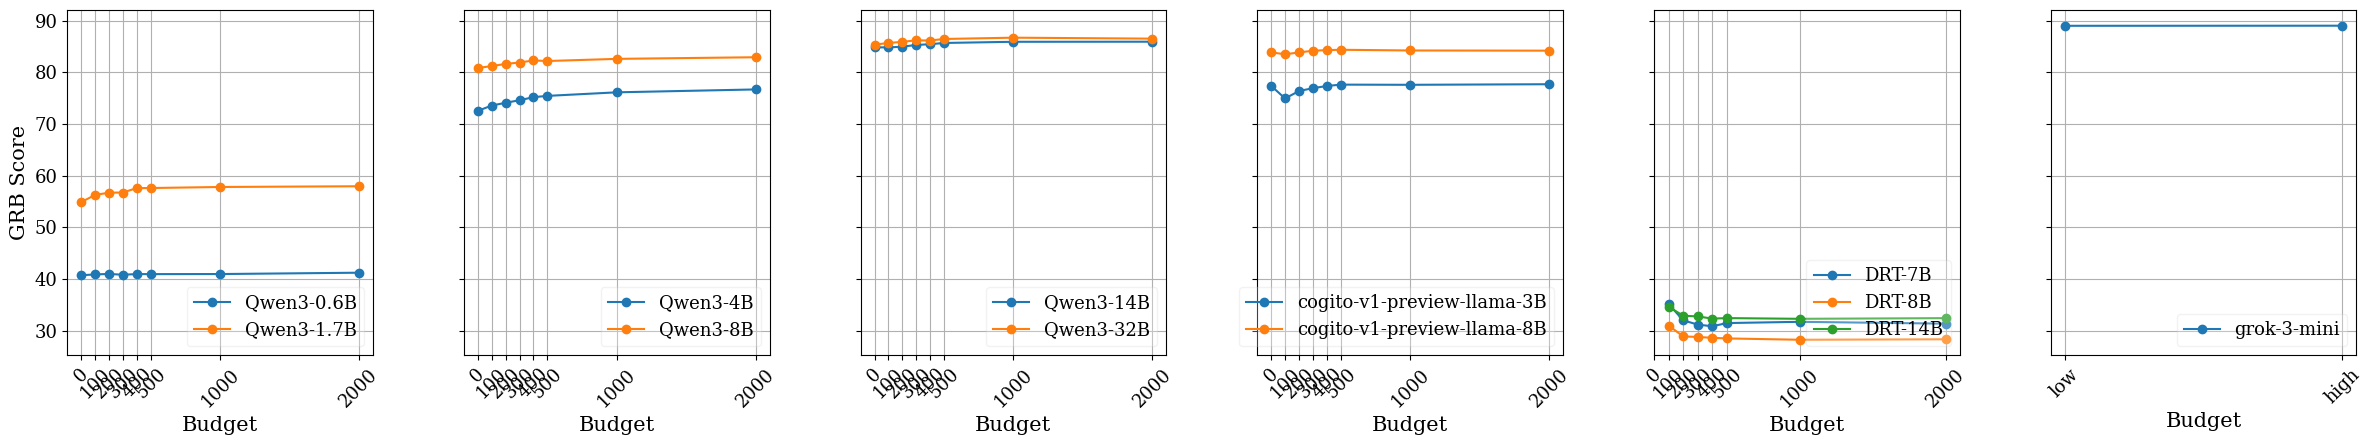

In [25]:
plot_models_groups_side_by_side(
    dfs_by_metric["grb"],
    task="CAMT",
    metric="grb",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["cogito-v1-preview-llama-3B", "cogito-v1-preview-llama-8B"],
        ["DRT-7B", "DRT-8B", "DRT-14B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5),
)

### Literterature Transaltion

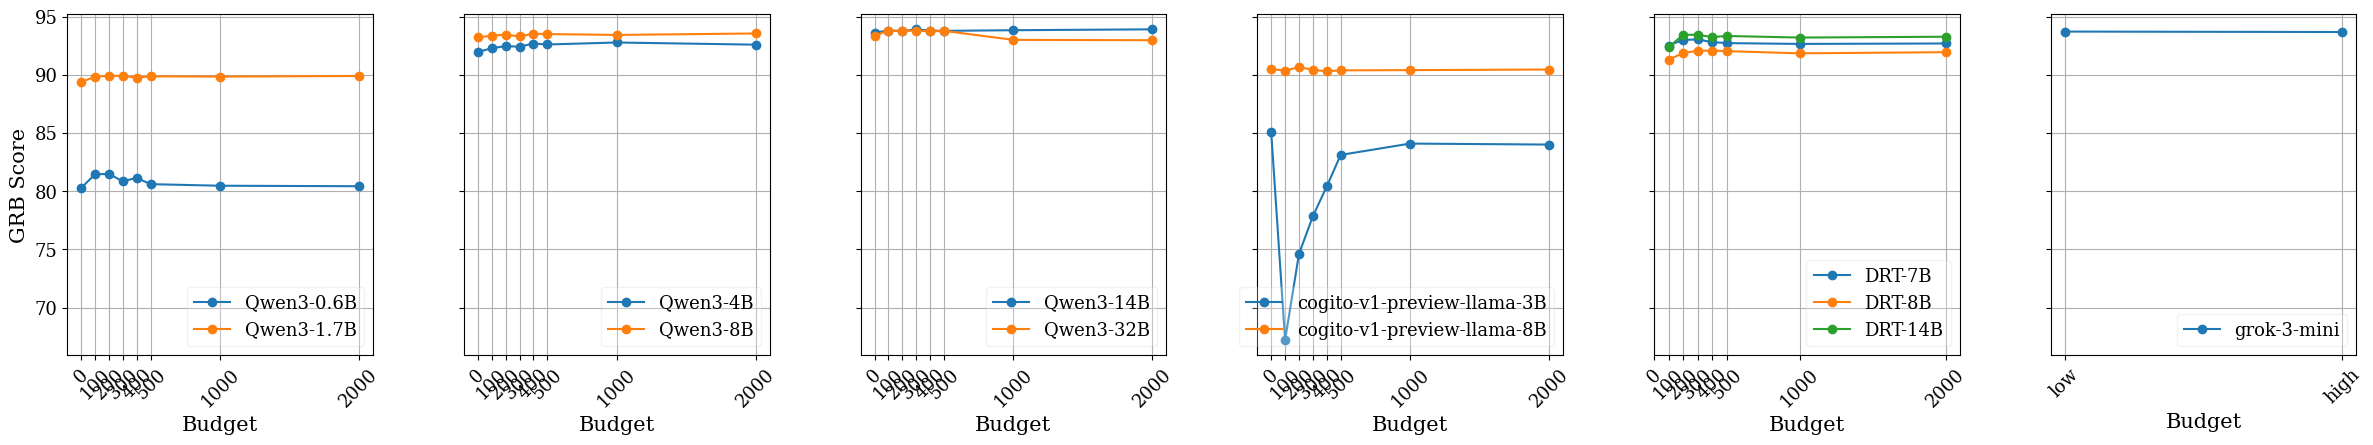

In [26]:
plot_models_groups_side_by_side(
    dfs_by_metric["grb"],
    task="DRT-Gutenberg",
    metric="grb",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["cogito-v1-preview-llama-3B", "cogito-v1-preview-llama-8B"],
        ["DRT-7B", "DRT-8B", "DRT-14B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5),
)

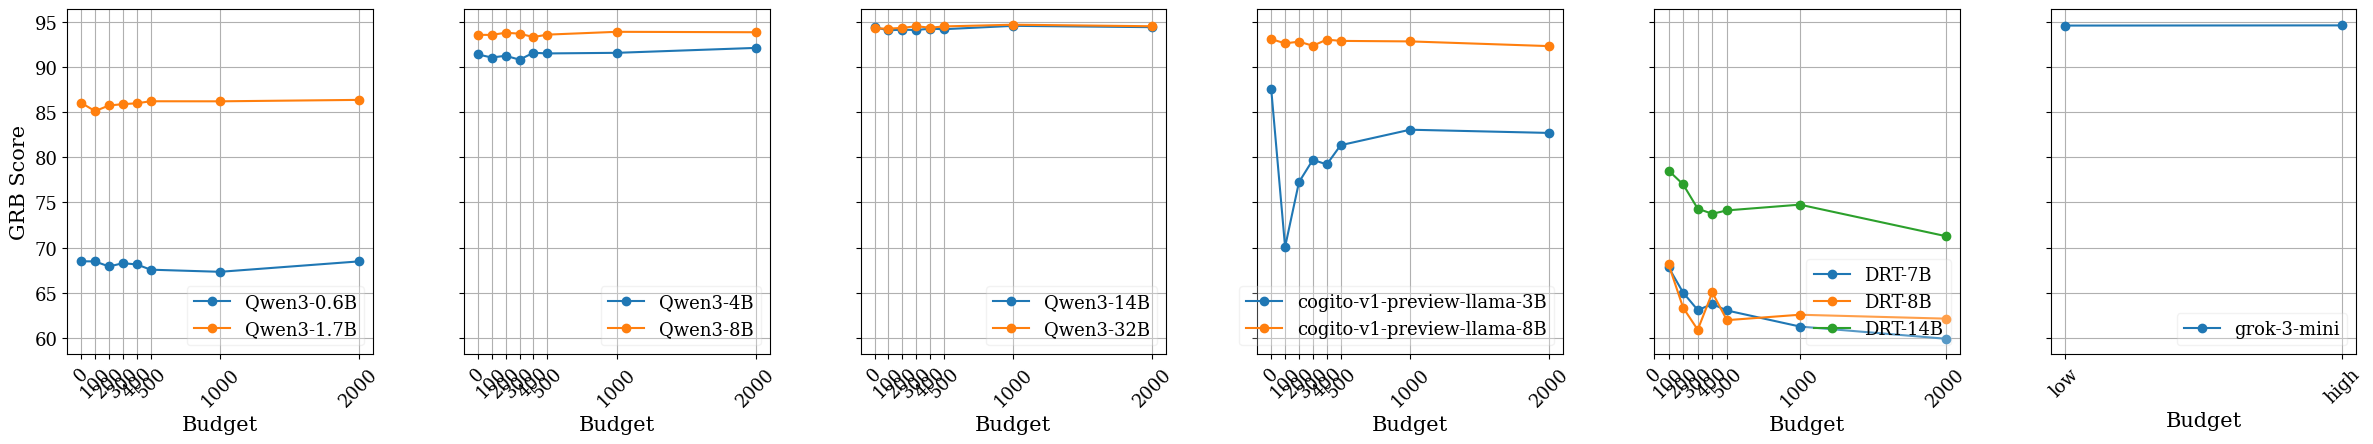

In [27]:
plot_models_groups_side_by_side(
    dfs_by_metric["grb"],
    task="LITEVAL-CORPUS",
    metric="grb",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["cogito-v1-preview-llama-3B", "cogito-v1-preview-llama-8B"],
        ["DRT-7B", "DRT-8B", "DRT-14B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5),
)

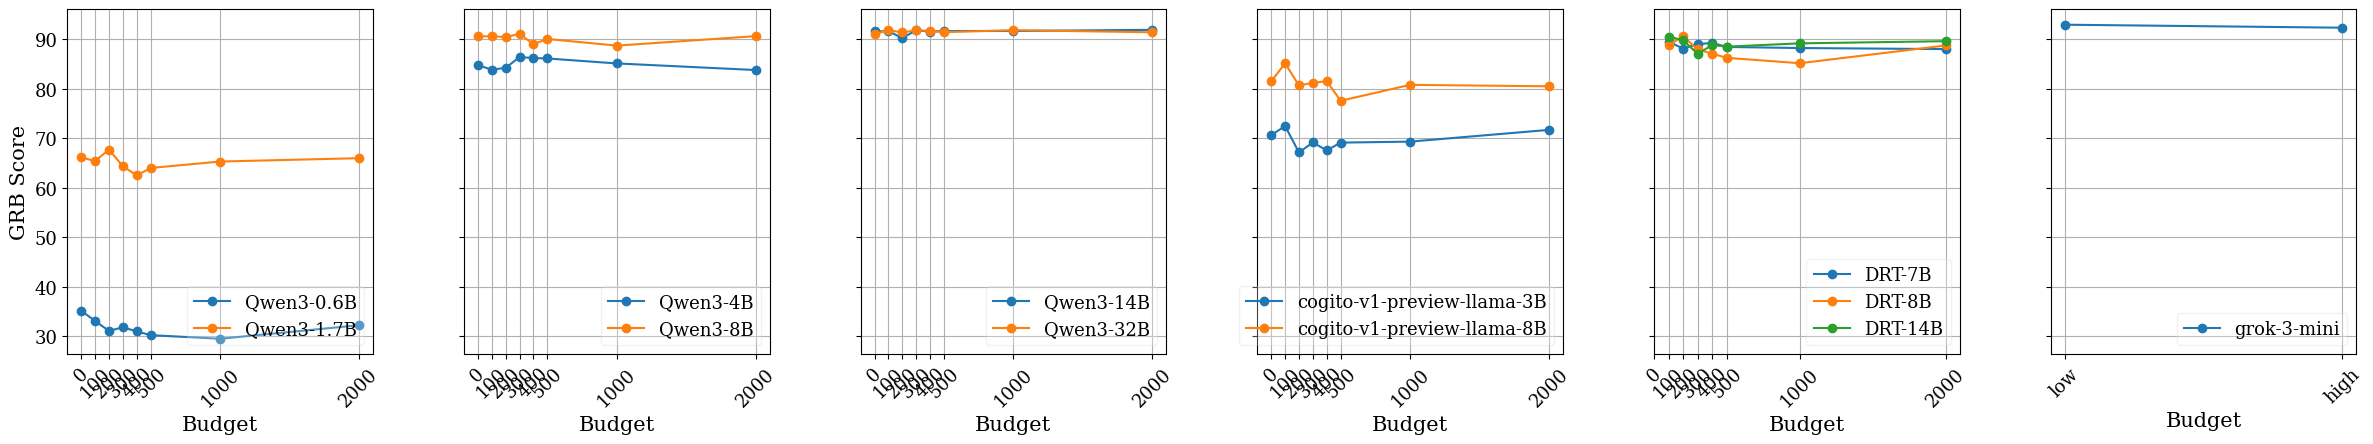

In [28]:
plot_models_groups_side_by_side(
    dfs_by_metric["grb"],
    task="WMT-Literary",
    metric="grb",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["cogito-v1-preview-llama-3B", "cogito-v1-preview-llama-8B"],
        ["DRT-7B", "DRT-8B", "DRT-14B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5),
)

### RAG Transaltion

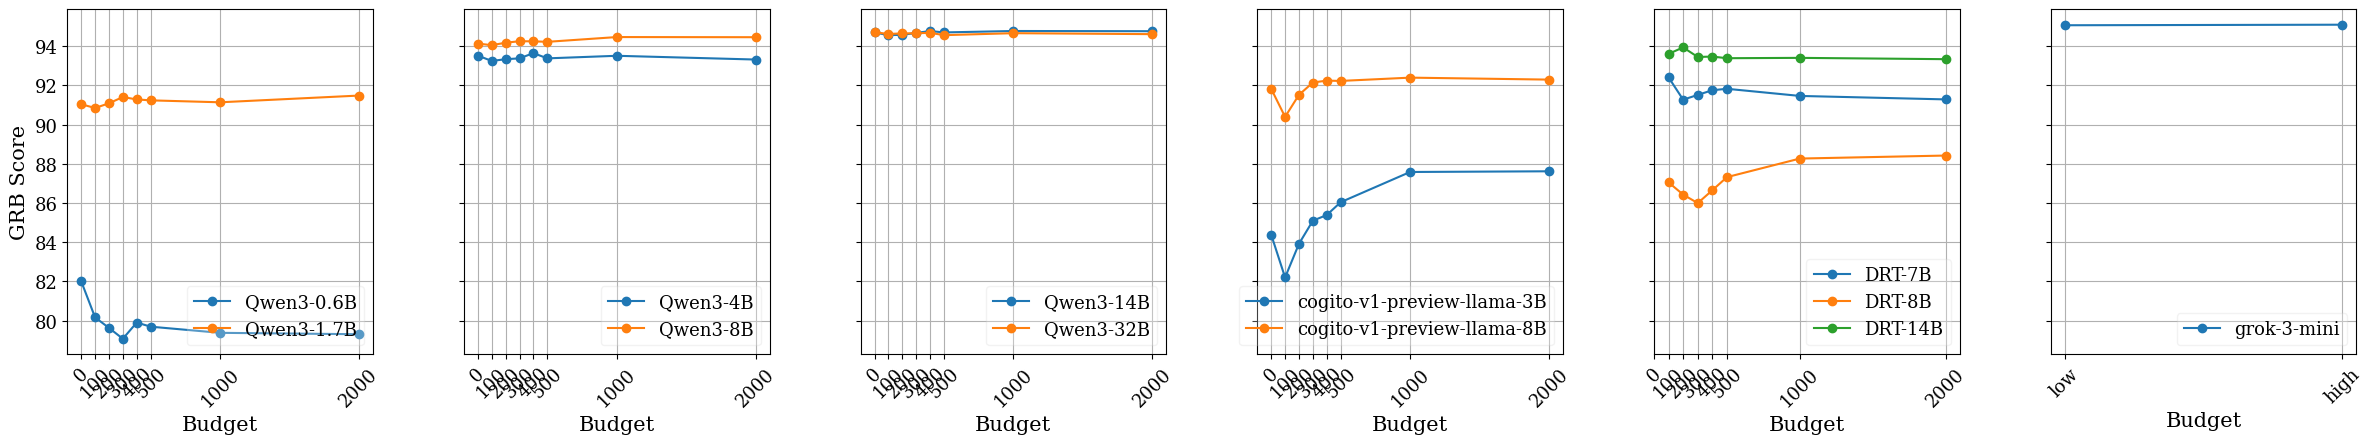

In [29]:
plot_models_groups_side_by_side(
    dfs_by_metric["grb"],
    task="RAGtrans",
    metric="grb",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["cogito-v1-preview-llama-3B", "cogito-v1-preview-llama-8B"],
        ["DRT-7B", "DRT-8B", "DRT-14B"],
        ["grok-3-mini"],
    ],
    budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    figsize=(24, 5),
)

### ALL Tasks

In [35]:
def calculate_average_scores_across_datasets(df, metric):
    """
    计算所有数据集（tasks）的平均分数
    
    参数:
    df: 包含所有数据的DataFrame
    metric: 指标名称 (如 'grb')
    
    返回:
    average_df: 包含平均分数的DataFrame，task列被设置为'Average-All-Datasets'
    """
    # 过滤指定的metric
    metric_df = df[df['metric'] == metric].copy()
    metric_df = metric_df[metric_df["task"] != "WMT23-Biomedical-Sentence"].reset_index(
        drop=True
    )

    if metric_df.empty:
        print(f"No data found for metric: {metric}")
        return pd.DataFrame()

    # 按 model, lang_pair, budget 分组，计算所有tasks的平均分数
    avg_df = metric_df.groupby(['model', 'lang_pair', 'budget'])['score'].mean().reset_index()

    # 添加其他必要的列
    avg_df['task'] = 'Average-All-Datasets'
    avg_df['metric'] = metric

    # 重新排列列的顺序以匹配原始DataFrame
    avg_df = avg_df[['model', 'task', 'metric', 'lang_pair', 'budget', 'score']]

    return avg_df


def rename_models(df):
    """统一重命名模型名称"""
    df = df.copy()
    df["model"] = df["model"].replace(
        "cogito-v1-preview-llama-3B", "Cogito-3B"
    )
    df["model"] = df["model"].replace(
        "cogito-v1-preview-llama-8B", "Cogito-8B"
    )
    df["model"] = df["model"].replace(
        "grok-3-mini", "Grok-3-Mini"
    )
    return df


# 计算GRB指标的平均分数
grb_average_df = calculate_average_scores_across_datasets(dfs_by_metric['grb'], 'grb')
grb_average_df = rename_models(grb_average_df)
print("GRB average scores calculated for all datasets")
print(f"Shape: {grb_average_df.shape}")
print("\nSample data:")
print(grb_average_df.head(10))

# 计算thinking_length指标的平均分数
thinking_length_average_df = calculate_average_scores_across_datasets(dfs_by_metric['thinking_length'], 'thinking_length')
thinking_length_average_df = rename_models(thinking_length_average_df)
print("\n\nThinking length average calculated for all datasets")
print(f"Shape: {thinking_length_average_df.shape}")
print("\nSample data:")
print(thinking_length_average_df.head(10))

GRB average scores calculated for all datasets
Shape: (1827, 6)

Sample data:
     model                  task metric lang_pair budget      score
0  DRT-14B  Average-All-Datasets    grb       Avg    100  74.562285
1  DRT-14B  Average-All-Datasets    grb       Avg    200  73.249521
2  DRT-14B  Average-All-Datasets    grb       Avg    300  72.281866
3  DRT-14B  Average-All-Datasets    grb       Avg    400  72.409775
4  DRT-14B  Average-All-Datasets    grb       Avg    500  72.486092
5  DRT-14B  Average-All-Datasets    grb       Avg   1000  72.593060
6  DRT-14B  Average-All-Datasets    grb       Avg   2000  72.049779
7  DRT-14B  Average-All-Datasets    grb     de-en    100  79.906262
8  DRT-14B  Average-All-Datasets    grb     de-en    200  73.946280
9  DRT-14B  Average-All-Datasets    grb     de-en    300  67.500848


Thinking length average calculated for all datasets
Shape: (1756, 6)

Sample data:
     model                  task           metric lang_pair budget       score
0  DRT-14B

In [36]:
def plot_average_scores_for_metric(metric_name, dfs_by_metric, model_groups=None, budget_ticks=None, figsize=(24, 5)):
    """
    为指定指标绘制所有数据集的平均分数图表
    
    参数:
    metric_name: 指标名称
    dfs_by_metric: 包含所有指标数据的字典
    model_groups: 模型分组列表
    budget_ticks: budget刻度
    figsize: 图表大小
    """
    if metric_name not in dfs_by_metric:
        print(f"Metric '{metric_name}' not found in available metrics: {list(dfs_by_metric.keys())}")
        return
    
    # 默认模型分组
    if model_groups is None:
        model_groups = [
            ["Qwen3-0.6B", "Qwen3-1.7B"],
            ["Qwen3-4B", "Qwen3-8B"],
            ["Qwen3-14B", "Qwen3-32B"],
            ["Cogito-3B", "Cogito-8B"],
            ["DRT-7B", "DRT-8B", "DRT-14B"],
            ["grok-3-mini"],
        ]
    
    # 默认budget刻度
    if budget_ticks is None:
        budget_ticks = [0, 100, 200, 300, 400, 500, 1000, 2000]
    
    # 计算平均分数
    avg_df = calculate_average_scores_across_datasets(dfs_by_metric[metric_name], metric_name)
    
    if avg_df.empty:
        print(f"No average data could be calculated for metric: {metric_name}")
        return
    
    # 绘制图表
    plot_models_groups_side_by_side(
        avg_df,
        task="Average-All-Datasets",
        metric=metric_name,
        lang_pair="Avg",
        model_groups=model_groups,
        budget_ticks=budget_ticks,
        figsize=figsize,
    )

# 示例：可以为其他指标也绘制平均分数图表
# plot_average_scores_for_metric('grf', dfs_by_metric)


In [63]:
def plot_models_groups_side_by_side_single_xlabel(
    df,
    task,
    metric,
    lang_pair,
    model_groups,
    budget_ticks=None,
    figsize=(16, 5),
    output_name=None,
):
    """
    与原函数相同，但只显示一个居中的x轴标签
    """
    n_groups = len(model_groups)
    fig, axes = plt.subplots(1, n_groups, figsize=figsize, sharey=True)
    if n_groups == 1:
        axes = [axes]

    for idx, models in enumerate(model_groups):
        ax = axes[idx]
        group_df = df[
            (df["task"] == task)
            & (df["metric"] == metric)
            & (df["lang_pair"] == lang_pair)
            & (df["model"].isin(models))
        ]
        if group_df.empty:
            ax.set_title("No data available for this group")
            continue

        # First, determine the nature of the budget axis for this group
        all_budgets = set(group_df["budget"])
        sorted_budgets = sorted(all_budgets, key=sort_budget_key)
        is_numeric_group = all(
            isinstance(b, (int, float)) or (isinstance(b, str) and b.isdigit())
            for b in sorted_budgets
        )

        # Plot each model in the group
        for model in models:
            sub = group_df[group_df["model"] == model].copy()
            if sub.empty:
                continue
            sub = sub.sort_values(by="budget", key=lambda x: x.map(sort_budget_key))

            x_values = sub["budget"]
            if is_numeric_group:
                # If all budgets are numeric-like, plot them as numbers
                x_values = x_values.astype(int)
            else:
                # Otherwise, plot as strings (categorical)
                x_values = x_values.astype(str)

            ax.plot(x_values, sub["score"], marker="o", label=model)

        # Set the x-ticks based on whether the axis is numeric or categorical
        if is_numeric_group:
            # For a numeric axis, set numeric ticks
            ticks = (
                budget_ticks
                if budget_ticks is not None
                else [int(b) for b in sorted_budgets]
            )
            ax.set_xticks(ticks)
            ax.set_xticklabels(ticks, rotation=45)
        else:
            # For a categorical axis, set string ticks
            xticks = [str(b) for b in sorted_budgets]
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticks, rotation=0)

        # 不在每个子图上设置xlabel
        # ax.grid(True)
        ax.grid(True, linestyle="--", linewidth=0.8, alpha=0.7)
        if idx == 0:
            ax.set_ylabel(f"{metric.upper()} Score")
        ax.legend(loc="lower right", framealpha=0.25)

    # 在整个图表底部添加一个居中的x轴标签
    fig.text(0.5, 0.02, 'Thinking Budget (Tokens)', ha='center')

    # plt.suptitle(f"{task} | {metric} | {lang_pair}")
    plt.tight_layout(rect=[0, 0.05, 1, 0.94])  # 为底部标签留出空间
    plt.savefig(output_name, dpi=900, bbox_inches="tight")
    plt.show()


def plot_models_groups_dual_axis(
    score_df,
    tokens_df,
    task,
    metric,
    lang_pair,
    model_groups,
    budget_ticks=None,
    figsize=(16, 5),
    output_name=None,
):
    """
    双Y轴绘图：左轴为平均thinking_length，右轴为GRB Score
    参考 drt_performance_vs_tokens.ipynb 的实现
    
    参数:
    score_df: GRB分数的DataFrame
    tokens_df: thinking_length的DataFrame
    task: 任务名称
    metric: 指标名称
    lang_pair: 语言对
    model_groups: 模型分组列表
    budget_ticks: budget刻度
    figsize: 图表大小
    output_name: 输出文件名
    """
    from matplotlib.lines import Line2D

    n_groups = len(model_groups)
    fig, axes = plt.subplots(1, n_groups, figsize=figsize)
    if n_groups == 1:
        axes = [axes]

    # 颜色映射 - 为每个模型分配颜色
    all_models = [m for group in model_groups for m in group]
    color_palette = plt.cm.tab10.colors
    color_map = {model: color_palette[i % len(color_palette)] for i, model in enumerate(all_models)}

    # marker映射
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    marker_map = {model: markers[i % len(markers)] for i, model in enumerate(all_models)}

    model_handles = {}

    for idx, models in enumerate(model_groups):
        ax_left = axes[idx]

        # 获取thinking_length数据
        tokens_group_df = tokens_df[
            (tokens_df["task"] == task)
            & (tokens_df["metric"] == "thinking_length")
            & (tokens_df["lang_pair"] == lang_pair)
            & (tokens_df["model"].isin(models))
        ]

        # 获取GRB分数数据
        score_group_df = score_df[
            (score_df["task"] == task)
            & (score_df["metric"] == metric)
            & (score_df["lang_pair"] == lang_pair)
            & (score_df["model"].isin(models))
        ]

        if tokens_group_df.empty and score_group_df.empty:
            ax_left.set_title("No data available for this group")
            continue

        # 确定budget轴的性质
        all_budgets = set()
        if not tokens_group_df.empty:
            all_budgets.update(tokens_group_df["budget"])
        if not score_group_df.empty:
            all_budgets.update(score_group_df["budget"])
        sorted_budgets = sorted(all_budgets, key=sort_budget_key)
        is_numeric_group = all(
            isinstance(b, (int, float)) or (isinstance(b, str) and b.isdigit())
            for b in sorted_budgets
        )

        # 左轴：绘制thinking_length（实线）
        for model in models:
            sub = tokens_group_df[tokens_group_df["model"] == model].copy()
            if sub.empty:
                continue
            sub = sub.sort_values(by="budget", key=lambda x: x.map(sort_budget_key))

            x_values = sub["budget"]
            if is_numeric_group:
                x_values = x_values.astype(int)
            else:
                x_values = x_values.astype(str)

            h = ax_left.plot(
                x_values,
                sub["score"],
                marker=marker_map.get(model, "o"),
                linestyle="-",
                linewidth=1.5,
                label=model,
                color=color_map.get(model),
            )[0]
            if model not in model_handles:
                model_handles[model] = h

        # 设置左轴标签
        if idx == 0:
            ax_left.set_ylabel("Actual Thinking Length")
        ax_left.tick_params(axis="y")

        # 创建右轴并绘制GRB分数（虚线）
        ax_right = ax_left.twinx()
        for model in models:
            sub = score_group_df[score_group_df["model"] == model].copy()
            if sub.empty:
                continue
            sub = sub.sort_values(by="budget", key=lambda x: x.map(sort_budget_key))

            x_values = sub["budget"]
            if is_numeric_group:
                x_values = x_values.astype(int)
            else:
                x_values = x_values.astype(str)

            ax_right.plot(
                x_values,
                sub["score"],
                marker=marker_map.get(model, "o"),
                linestyle="--",
                linewidth=1.5,
                color=color_map.get(model),
                alpha=0.9,
            )

        # 设置右轴标签（只在最后一个子图显示）
        if idx == n_groups - 1:
            ax_right.set_ylabel(f"{metric.upper()} Score")
        else:
            ax_right.set_yticklabels([])
        ax_right.tick_params(axis="y")

        # 设置x轴刻度
        if is_numeric_group:
            ticks = (
                budget_ticks
                if budget_ticks is not None
                else [int(b) for b in sorted_budgets]
            )
            ax_left.set_xticks(ticks)
            ax_left.set_xticklabels(ticks, rotation=0)
        else:
            xticks = [str(b) for b in sorted_budgets]
            ax_left.set_xticks(xticks)
            ax_left.set_xticklabels(xticks, rotation=0)

        ax_left.grid(True, linestyle="--", linewidth=0.8, alpha=0.7)

    # 创建图例
    # 模型图例
    model_order = [m for group in model_groups for m in group]
    model_handles_ordered = [model_handles[m] for m in model_order if m in model_handles]
    model_labels_ordered = [m for m in model_order if m in model_handles]

    # 样式图例
    style_handles = [
        Line2D([0], [0], color="black", linestyle="-", marker="o", label="Actual Thinking Length"),
        Line2D([0], [0], color="black", linestyle="--", marker="o", label=f"{metric.upper()} Score"),
    ]
    style_labels = [h.get_label() for h in style_handles]

    # 合并图例
    all_handles = model_handles_ordered + style_handles
    all_labels = model_labels_ordered + style_labels

    fig.legend(
        all_handles,
        all_labels,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.01),
        ncol=len(all_handles),
        frameon=True,
    )

    # 在整个图表底部添加一个居中的x轴标签
    fig.text(0.5, -0.05, 'Thinking Budget (Tokens)', ha='center')

    plt.tight_layout(rect=[0, 0.12, 1, 0.94])

    if output_name:
        plt.savefig(output_name, dpi=900, bbox_inches="tight")
    plt.show()

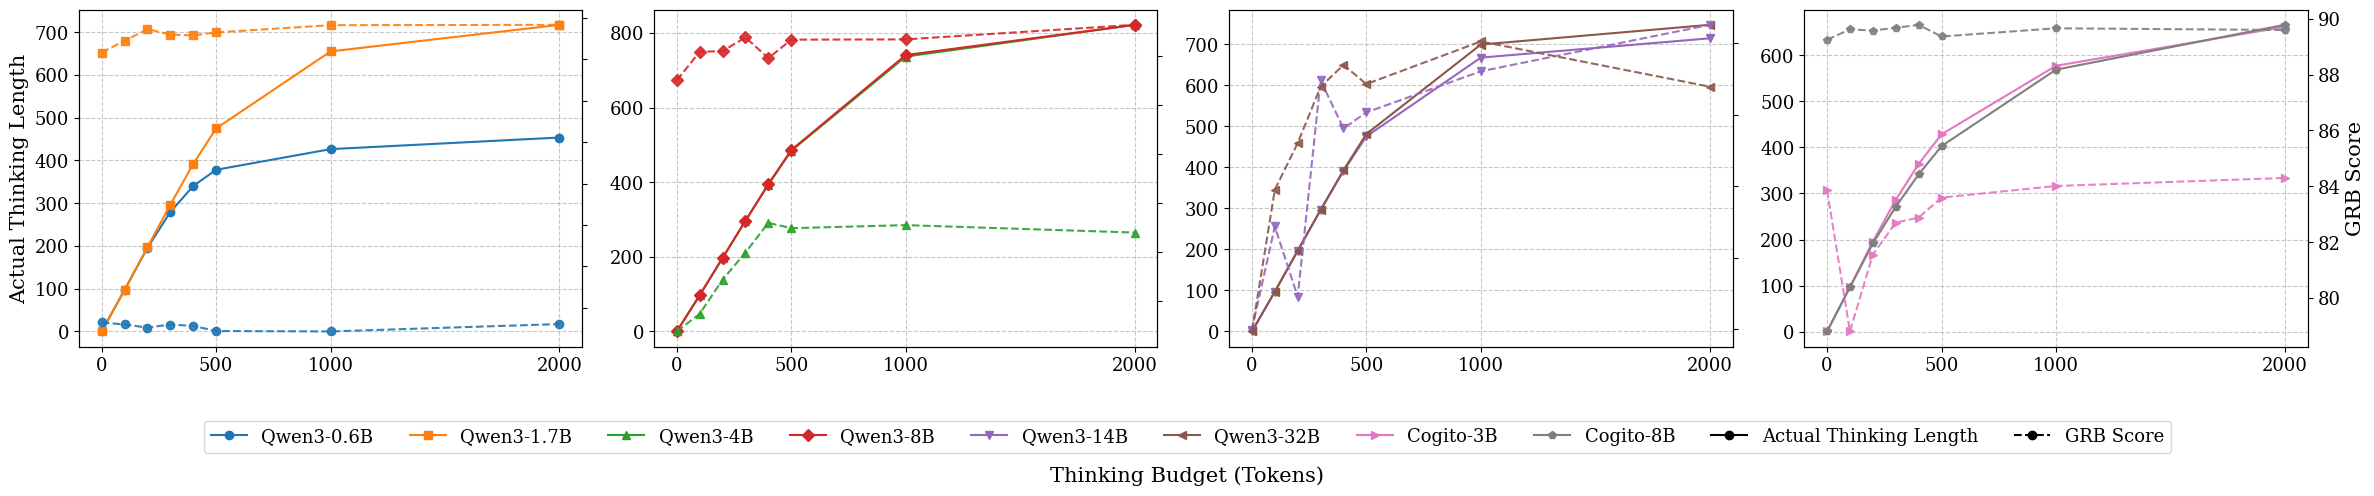

In [64]:
# 使用双Y轴函数绘制平均分数图表
# 左轴：平均thinking_length，右轴：GRB Score
plot_models_groups_dual_axis(
    score_df=grb_average_df,
    tokens_df=thinking_length_average_df,
    task="Average-All-Datasets",
    metric="grb",
    lang_pair="Avg",
    model_groups=[
        ["Qwen3-0.6B", "Qwen3-1.7B"],
        ["Qwen3-4B", "Qwen3-8B"],
        ["Qwen3-14B", "Qwen3-32B"],
        ["Cogito-3B", "Cogito-8B"],
        # ["DRT-7B", "DRT-8B", "DRT-14B"],
        # ["grok-3-mini"],
    ],
    # budget_ticks=[0, 100, 200, 300, 400, 500, 1000, 2000],
    budget_ticks=[0, 500, 1000, 2000],
    # budget_ticks=[0, 100, 200, 300, 400, 500, 1000],
    figsize=(24, 5),
    output_name="qwen_and_cogito_grb_average.png",
    # output_name="qwen_and_cogito_grb_average.pdf",
)

In [34]:
def latex_table_for_metric(
    df: pd.DataFrame,
    task="Average-All-Datasets",
    metric_name="comet_score",
    budgets_order=(100, 200, 300, 500, 1000, 2000, "low", "high"),
    float_digits=3,
    caption="Average performance across budgets",
    label="tab:avg_comet",
):
    sub = df[(df["task"] == task) & (df["metric"] == metric_name)].copy()

    # 统一 budget 类型（把能转成整数的先转掉）
    def norm_budget(x):
        try:
            return int(x)
        except Exception:
            return x

    sub["budget"] = sub["budget"].map(norm_budget)

    # 列顺序
    budgets = [b for b in budgets_order if b in sub["budget"].unique().tolist()]
    sub["budget"] = pd.Categorical(sub["budget"], categories=budgets, ordered=True)

    # 透视成宽表（数值）
    wide = sub.pivot_table(
        index="model", columns="budget", values="score", aggfunc="mean"
    )
    wide = wide.reindex(columns=budgets)

    # -------- 生成字符串版并加粗行内最大值 --------
    formatted = wide.applymap(lambda v: f"{v:.{float_digits}f}" if pd.notna(v) else "")

    row_max = wide.max(axis=1, skipna=True)  # 每行最大值
    for idx in wide.index:
        for col in wide.columns:
            v = wide.loc[idx, col]
            # if pd.notna(v) and np.isclose(v, row_max.loc[idx]):
            #     formatted.loc[idx, col] = f"\\textbf{{{float(v):.{float_digits}f}}}"

    formatted.index.name = "Model"
    formatted.columns = [str(c) for c in formatted.columns]

    latex = formatted.to_latex(
        escape=False,
        index=True,
        column_format="l" + "c" * formatted.shape[1],
        caption=caption,
        label=label,
        longtable=False,
        multicolumn=True,
        multicolumn_format="c",
        bold_rows=False,
    )
    return latex


latex_code = latex_table_for_metric(
    grb_average_df,
    task="Average-All-Datasets",
    metric_name="grb",
    budgets_order=(0, 100, 200, 300, 500, 1000, 2000, "low", "high"),
)
print(latex_code)

\begin{table}
\caption{Average performance across budgets}
\label{tab:avg_comet}
\begin{tabular}{lccccccccc}
\toprule
 & 0 & 100 & 200 & 300 & 500 & 1000 & 2000 & low & high \\
Model &  &  &  &  &  &  &  &  &  \\
\midrule
Cogito-3B & 82.546 & 78.016 & 79.590 & 80.571 & 81.176 & 81.497 & 81.937 &  &  \\
Cogito-8B & 88.177 & 88.552 & 88.312 & 88.402 & 87.948 & 88.432 & 88.351 &  &  \\
DRT-14B &  & 67.932 & 65.369 & 64.878 & 64.944 & 64.615 & 63.817 &  &  \\
DRT-7B &  & 60.176 & 57.563 & 56.554 & 55.073 & 50.192 & 49.233 &  &  \\
DRT-8B &  & 60.984 & 59.385 & 57.302 & 55.833 & 55.326 & 55.702 &  &  \\
Grok-3-Mini &  &  &  &  &  &  &  & 92.529 & 92.451 \\
Qwen3-0.6B & 58.165 & 57.507 & 57.518 & 57.813 & 57.317 & 57.372 & 57.734 &  &  \\
Qwen3-1.7B & 74.422 & 74.634 & 75.522 & 74.883 & 75.076 & 75.678 & 75.753 &  &  \\
Qwen3-14B & 90.899 & 90.875 & 90.707 & 91.075 & 91.163 & 91.253 & 91.294 &  &  \\
Qwen3-32B & 90.949 & 91.103 & 91.204 & 91.333 & 91.340 & 91.556 & 91.455 &  &  \\
Qwen3-4B &

C:\Users\zihao\AppData\Local\Temp\ipykernel_11408\3700933795.py:26: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wide = sub.pivot_table(
C:\Users\zihao\AppData\Local\Temp\ipykernel_11408\3700933795.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted = wide.applymap(lambda v: f"{v:.{float_digits}f}" if pd.notna(v) else "")
